In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
sns.set()

# Set Pandas options to show all columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Make variable for input file
INFILE = "/Users/jck/Documents/MSDS 422/Unit 2/Assignment 2/HMEQ_Loss.csv"

# Read in the data file
df = pd.read_csv(INFILE, sep=',', header=0)

#print( df.head() )



In [2]:
df.head(5)

,TARGET_BAD_FLAG,TARGET_LOSS_AMT,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,641.0,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1109.0,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,767.0,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1425.0,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
cols_with_missing = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
'''
I observed that some data points are outliers, so I plan to employ the Interquartile Range (IQR) method 
to detect these outliers and substitute them, using the median value for imputation.
'''
for col in cols_with_missing:
    # 1. Identify Outliers using the IQR method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 2. Remove Outliers - Replace outliers in a copy of the column with NaN
    temp_col = df[col].copy()
    temp_col[(temp_col < lower_bound) | (temp_col > upper_bound)] = np.nan
    
    # 3. Calculate median of the column with outliers removed
    median_val = temp_col.median()
    
    # 4. Create new column for imputed values, fill missing values with the calculated median
    df['IMP_'+col] = df[col].fillna(median_val)

In [4]:
X = df.drop([ 'TARGET_LOSS_AMT', 'REASON', 'JOB','MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC','IMP_NINQ','IMP_DEROG','IMP_DELINQ'], axis=1)
TARGET = "TARGET_BAD_FLAG"
X = X.drop( [TARGET], axis=1 )
varNames = X.columns
print(X.head(5))

   LOAN  IMP_MORTDUE  IMP_VALUE  IMP_YOJ   IMP_CLAGE  IMP_CLNO  IMP_DEBTINC
0  1100      25860.0    39025.0     10.5   94.366667       9.0    34.880462
1  1300      70053.0    68400.0      7.0  121.833333      14.0    34.880462
2  1500      13500.0    16700.0      4.0  149.466667      10.0    34.880462
3  1500      63508.0    86908.0      7.0  172.432355      20.0    34.880462
4  1700      97800.0   112000.0      3.0   93.333333      14.0    34.880462


In [5]:
# TRANSFROM
theScaler = MinMaxScaler()
theScaler.fit( X )

X_TRN = theScaler.transform( X )
X_TRN = pd.DataFrame( X_TRN )
print( X_TRN.head() )

varNames_trn = []
for i in varNames :
    newName = "trn_" + i
    varNames_trn.append( newName )
print( varNames_trn )

X_TRN.columns = varNames_trn

          0         1         2         3         4         5         6
0  0.000000  0.059869  0.036590  0.256098  0.080777  0.126761  0.169418
1  0.002252  0.171050  0.071234  0.170732  0.104289  0.197183  0.169418
2  0.004505  0.028773  0.010261  0.097561  0.127942  0.140845  0.169418
3  0.004505  0.154584  0.093062  0.170732  0.147601  0.281690  0.169418
4  0.006757  0.240856  0.122655  0.073171  0.079893  0.197183  0.169418
['trn_LOAN', 'trn_IMP_MORTDUE', 'trn_IMP_VALUE', 'trn_IMP_YOJ', 'trn_IMP_CLAGE', 'trn_IMP_CLNO', 'trn_IMP_DEBTINC']


In [6]:
K_LIST = []
I_LIST = []
S_LIST = []
C_LIST = []

for K in range(3,12) :
    km = KMeans( n_clusters=K, random_state = 1 )
    km.fit( X_TRN )
    # Y = km.predict( X_TRN )
    K_LIST.append( K )
    I_LIST.append( km.inertia_ )
    S_LIST.append( silhouette_score(X_TRN,km.labels_) )
    C_LIST.append( calinski_harabasz_score(X_TRN,km.labels_) )

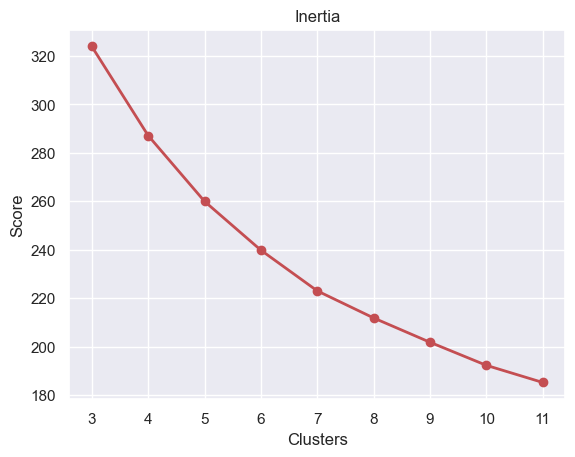

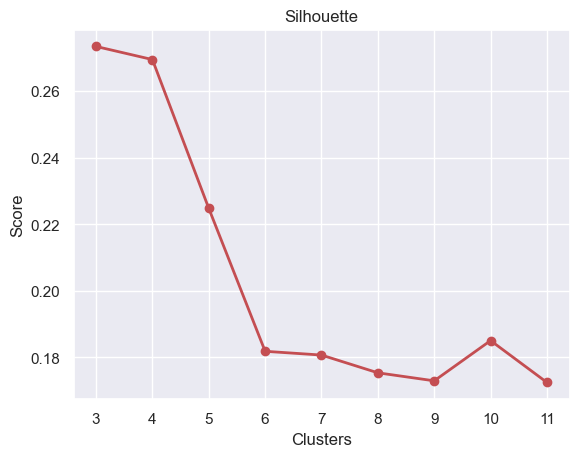

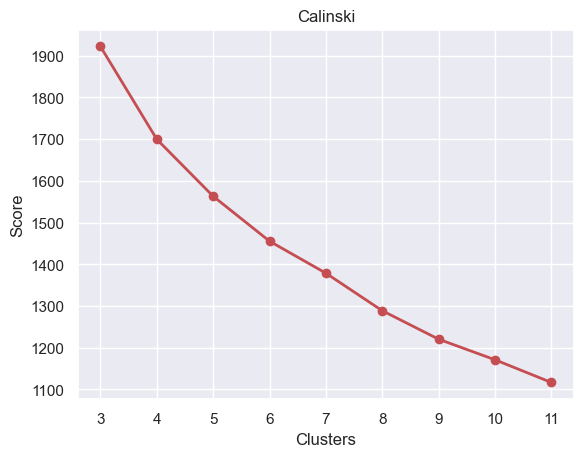

In [7]:
def drawElbow( K, SCORE, LABEL ) :
    plt.plot( K , SCORE, 'ro-', linewidth=2)
    plt.title(LABEL)
    plt.xlabel('Clusters')
    plt.ylabel('Score')
    plt.show()


drawElbow( K_LIST, I_LIST, "Inertia" )
drawElbow( K_LIST, S_LIST, "Silhouette" )
drawElbow( K_LIST, C_LIST, "Calinski" )



In [8]:
def clusterData( DATA, TRN_DATA, K, TARGET ) :
    print("\n\n\n")
    print("K = ",K)
    print("=======")
    km = KMeans( n_clusters=K, random_state = 1 )
    km.fit( TRN_DATA )
    Y = km.predict( TRN_DATA )
    DATA["CLUSTER"] = Y
    print( DATA.head() )

    G = DATA.groupby("CLUSTER")
    print( G.mean(numeric_only=True)  )
    print("\n\n\n")
    print( G[ TARGET ].value_counts() )

In [9]:
clusterData( df, X_TRN, 3, TARGET )





K =  3
   TARGET_BAD_FLAG  TARGET_LOSS_AMT  LOAN  MORTDUE     VALUE   REASON     JOB  \
0                1            641.0  1100  25860.0   39025.0  HomeImp   Other   
1                1           1109.0  1300  70053.0   68400.0  HomeImp   Other   
2                1            767.0  1500  13500.0   16700.0  HomeImp   Other   
3                1           1425.0  1500      NaN       NaN      NaN     NaN   
4                0              NaN  1700  97800.0  112000.0  HomeImp  Office   

    YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  DEBTINC  IMP_MORTDUE  \
0  10.5    0.0     0.0   94.366667   1.0   9.0      NaN      25860.0   
1   7.0    0.0     2.0  121.833333   0.0  14.0      NaN      70053.0   
2   4.0    0.0     0.0  149.466667   1.0  10.0      NaN      13500.0   
3   NaN    NaN     NaN         NaN   NaN   NaN      NaN      63508.0   
4   3.0    0.0     0.0   93.333333   0.0  14.0      NaN      97800.0   

   IMP_VALUE  IMP_YOJ  IMP_DEROG  IMP_DELINQ   IMP_CLAGE  IMP_NINQ  I

# Answering the questions:

If possible, try to tell a story of the people who are members of each cluster. Do the clusters make sense?

Cluster 0:

This cluster appears to have the highest values in VALUE and CLAGE (age of oldest credit line) which suggests members of this cluster might have higher property values and more mature credit lines. They have a moderate number of derogatory reports (DEROG) and delinquent lines (DELINQ), and their debt-to-income ratio (DEBTINC) is the lowest among the clusters. The number of recent credit lines (NINQ) is high.
The TARGET_BAD_FLAG indicates fewer defaults in this cluster compared to the others.
Given these attributes, members of this cluster might represent more established borrowers with stable finances but who are still actively seeking credit.

Cluster 1:

This cluster has moderate property values and the youngest credit lines on average (CLAGE). They have the lowest number of derogatory reports and delinquent lines but a higher debt-to-income ratio than Cluster 0.
The TARGET_BAD_FLAG shows a higher rate of defaults compared to Cluster 0, which might suggest that despite having fewer derogatory marks, the higher debt-to-income ratio affects their ability to pay back loans.
Members of this cluster could be newer borrowers who have yet to establish a long credit history and may be at a higher risk of default due to higher leverage in their financial profiles.

Cluster 2:

Members in this cluster have the highest average number of derogatory reports and delinquent lines, suggesting a history of credit issues. They have the longest credit lines (CLAGE), which may imply that they are older individuals or businesses that have been managing credit for a longer period.
Despite the longer credit history, they have a high debt-to-income ratio and the number of recent inquiries is the lowest, which could indicate financial distress or a more conservative approach to acquiring new credit.
This cluster has the highest TARGET_BAD_FLAG count, indicating the highest probability of loan default.

Do the clusters make sense?

Based on the data provided, the clusters do seem to make sense as they show distinct groups with different risk profiles based on their credit history, current financial leverage, and credit line age.

Cluster 0 may represent a lower risk group with stable financial history and active credit usage.
Cluster 1 may represent a moderate risk group with less established credit history and higher leverage.
Cluster 2 appears to be the highest risk group with a history of credit problems and the highest probability of default.

In terms of determining the Probability of Loan Default (as indicated by TARGET_BAD_FLAG) and Loss Amount given default:

The TARGET_BAD_FLAG provides a direct way to estimate the probability of default: the higher the count of 1s in relation to 0s within a cluster, the higher the probability of default for that cluster.
However, the output does not directly show Loss Amount given default, and I do not think clusters can determine loss amount.

In [10]:
!jupyter nbconvert --to pdf Assignment_unit99_Kmeans.ipynb

[NbConvertApp] Converting notebook Assignment_unit99_Kmeans.ipynb to pdf
[NbConvertApp] Support files will be in Assignment_unit99_Kmeans_files/
[NbConvertApp] Making directory ./Assignment_unit99_Kmeans_files
[NbConvertApp] Writing 42988 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 123953 bytes to Assignment_unit99_Kmeans.pdf
